# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.352371,False,-2.800845
1,1.840101,True,5.312718
2,1.462809,True,5.135988
3,-1.268049,False,-0.090203
4,-1.062236,False,1.062694
...,...,...,...
995,0.278762,False,0.058603
996,1.429788,True,9.476343
997,-2.136987,False,-2.413670
998,-2.070323,False,-1.066857


<Axes: xlabel='v0'>

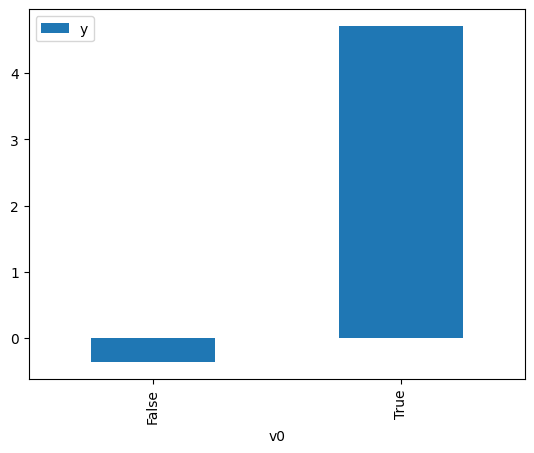

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

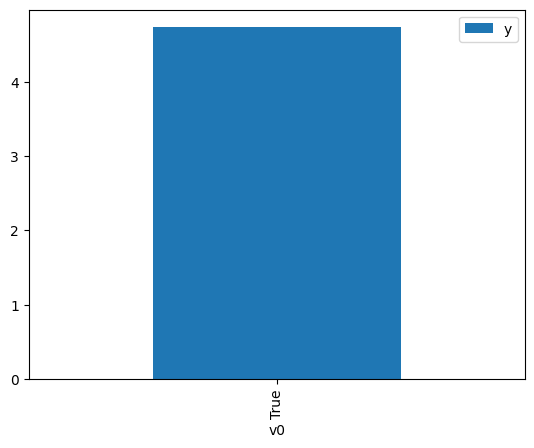

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.404146,False,3.487173,0.221540,4.513856
1,-0.119822,False,0.453772,0.542849,1.842132
2,-0.614196,False,0.697349,0.611026,1.636591
3,-0.064320,False,1.124111,0.535044,1.869006
4,-0.137764,False,-1.384972,0.545368,1.833623
...,...,...,...,...,...
995,-0.776681,False,-1.094488,0.632648,1.580659
996,0.397365,False,0.620665,0.469811,2.128515
997,0.713727,False,2.663563,0.425568,2.349803
998,1.595413,False,2.558598,0.310243,3.223276


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.607244,True,3.065915,0.389909,2.564699
1,-0.777414,True,4.223191,0.367256,2.722898
2,-2.025207,True,2.215251,0.222658,4.491188
3,-1.701738,True,1.773618,0.255943,3.907120
4,-0.578541,True,5.247765,0.393781,2.539485
...,...,...,...,...,...
995,0.044282,True,5.576950,0.480276,2.082137
996,-2.149224,True,1.854231,0.210746,4.745046
997,-0.777414,True,4.223191,0.367256,2.722898
998,1.066502,True,5.893722,0.622371,1.606758


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6487.
Date:                Mon, 25 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:24:16   Log-Likelihood:                         -1372.1
No. Observations:                1000   AIC:                                      2748.
Df Residuals:                     998   BIC:                                      2758.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0182      0.028     36.171      0.000       0.963       1.073
x2             5.0284      0.046    108.991      0.000       4.938       5.119
==============================================================================
Omnibus:                        2.186   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.335   Jarque-Bera (JB):                2.056
Skew:                           0.045   Prob(JB):                        0.358
Kurtosis:                       2.797   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""